In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_context("paper", font_scale=2.)
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

/Users/tj/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [85]:
datafile = "sm_37_90.csv"
df = pd.read_csv(datafile)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
lag_max = 3
lag_keys = []
for lag in range(1, lag_max+1):
    key = 'soil_moisture_%i' % lag
    df[key] = np.nan
    df[key][lag:] = df['soil_moisture'][:-lag]
    lag_keys += [key]

df = df.dropna()
train_num = 800
X = df[['LST_Day_1km', 'prcp'] + lag_keys].values
X2 = X.copy()**2
X = np.concatenate([X, X2], axis=1)
y = df.soil_moisture.values
X_train, X_test = X[:train_num], X[train_num:]
y_train, y_test = y[:train_num], y[train_num:]

In [86]:
model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_train).tolist()

for j, row in enumerate(X_test):
    prev_lags = np.asarray(y_hat[-lag_max:][::-1])
    row[2:lag_max+2] = prev_lags
    row[lag_max+4:] = prev_lags**2
    y_hat += model.predict(row[np.newaxis,:]).tolist()

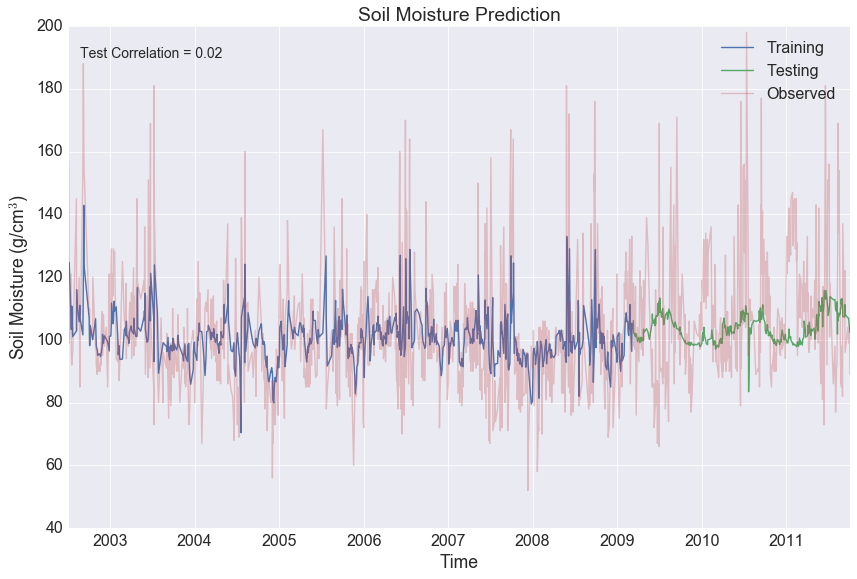

In [105]:
plt.figure(figsize=(14, 9))
plt.plot(df.index[:train_num], y_hat[:train_num], label="Training")
plt.plot(df.index[train_num:], y_hat[train_num:], label="Testing") #, color='red')
plt.plot(df.index, y, alpha=0.3, label='Observed')
plt.xlabel("Time")
plt.ylabel("Soil Moisture (g/cm$^3$)")
plt.legend()
plt.title("Soil Moisture Prediction")
corr = np.corrcoef(y_hat[train_num:], y[train_num:])[1,0]
plt.text(df.index[10], 190, "Test Correlation = %0.2f" % corr, fontdict=dict(fontsize=14))
plt.savefig("soil-moisture-prediction.pdf")